# Objekterkennung und Tracking á la CbTRAM

Der Ansatz aus Zinner et al. (2008) könnte interessant sein, um die Objektdefinition zu verbessern. Der Ansatz basiert auf drei Stadien. Interessant sind insbesondere die Definitionen der ersten beiden Stadien und die Verwendung der Bewegungsfelder.

Doch zunächst benötigen wir einige Pakete.

In [72]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import datetime as dt

from scipy import ndimage as ndi

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import tracking_common as tc

from analysis_tools import optical_flow as oflow
import l15_msevi.msevi as msv

sys.path.append("/vols/talos/home/stephan/test/msevi_std2hires/")
import msevi_std2hires as msh

## Stadium 1: konvektive Auslösung

Der Ansatz für das erste Stadium geht vom HRV-Kanal aus. Die Grundidee ist, Wolken zu finden, die wachsen. Dazu wird das HRV-Bild eines Zeitpunktes t mit dem des Zeitpunktes t-1 verglichen. Das Bild des Zeitpunktes t-1 wird mittels eines Flussfeldes verschoben und dann die Differenz ΔHRV = HRV$_\mathrm{t}$ – HRV$_\mathrm{t-1}$ gebildet. Das Flussfeld wird dabei NICHT von den HRV-Bildern abgeleitet sondern aus den gelätteten IR10.8-Bildern der Zeisschritte t-2 und t-1, da die Bewegung im Flussfeld aus den HRV-Bildern nicht nur aus der Advektion sondern auch aus den Entwicklungen herrührt, die analysiert werden sollen.

Das ΔHRV wird mit einem ΔIR-Feld verglichen, dass so ähnlich wie das ΔHRV-Feld abgeleitet wird, nur dass das Bewegungsfeld dafür aus dem WV062-Kanal stammt. Da sich nicht alle Wolken im HRV konvektiv sind und sich auch nicht alle Cumuli humiles zu Cumolonimbi entwicklen, werden nur Wolken betrachtete, deren Flächenzunahme durch eine eine Abkühlung im IR-Feld gestützt wird. Dafür wird ein Qualitätsindikator aus den beiden Feldern ΔHRV und ΔIR gebildete. Dafür weden sie zunächst dann normalisiert und dann multipliziert um das Qualit#tsfeld -ΔHRV $\cdot$ ΔIR zu erhalten, das Bereiche mit Wolkenwachstum anzeigt.

Um das auszuprobieren laden wir zunächst die Satellitendaten für ein Beispiel. Da das Verfahren vom HRV-Kanal ausgeht, müssen die Auflösungen angepasst werden. Damit keine Informationen verloren gehen, erhöhen wir die Auflösung der Kanäle mit Standardauflösung. Das geht mit Hartwigs Werkzeug.

In [68]:
t = t0
s = msv.MSevi(time=t,chan_list=sat_fields)
s.rad2bt()
s.rad2refl()

Region suggests use of hdf file


In [82]:
s.sat_type.lower()
mtf_file_name = "{}{}_mtf.xls".format(mtf_path,s.sat_type.lower())

In [83]:
mtf_file_name

pd.

'/vols/talos/home/stephan/test/msevi_std2hires/msg1_mtf.xls'

In [155]:
t2 = dt.datetime(2012,7,28,11,50) # t-2
t1 = dt.datetime(2012,7,28,11,55) # t-1
t0 = dt.datetime(2012,7,28,12,0) # t0

sat_fields = ['HRV','IR_108','WV_062']

region = ((216, 456), (1676, 2076))

sat_data = {f:[] for f in sat_fields}
#mtf_path = "/vols/talos/home/stephan/test/msevi_std2hires/"
for t in [t2,t1,t0]:
    s = msv.MSevi(time=t,chan_list=sat_fields,region=region)
    s.rad2bt()
    s.rad2refl()
 
   # mtf_file_name = "{}{}_mtf.xls".format(mtf_path,s.sat_type.lower())
    
    # Auflösung erhöhen
    for field in sat_fields[1:]:
        #mtf_data = msh.mtf.read_mtf(mtf_file_name,field.lower())
        #freq_filter = msh.mtf.filter(s.bt[field].shape,mtf_data,3)
        
        # Tukey-Fenster definieren
        #x0 = 300 # 320
        #nx = 688 # 400
        #y0 = 400 # 60
        #ny = 520 # 240
        #bx = 56
        #by = 40

        # region slice
        #sx = slice(x0,x0+nx)
        #sy = slice(y0,y0+ny)

        # region slice with border
        #bsx = slice(x0-bx,x0+nx+bx)
        #bsy = slice(y0-by,y0+ny+by)

        #win_lr = msh.get_tukey2d( (ny+2*by,nx+2*bx), (float(2*by)/(ny+2*by),float(2*bx)/(nx+2*bx)) )
        #win_hr = msh.get_tukey2d( (3*(ny+2*by),3*(nx+2*bx)), (float(2*by)/(ny+2*by),float(2*bx)/(nx+2*bx)) )
        
        im = msh.upsample_image(s.bt[field],1,0)#,win_lr)
        #im = im[3*by:3*(by+ny),3*bx:3*(bx+nx)]
        sat_data[field].append(im)
    
    sat_data['HRV'].append(s.ref['HRV'])


Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file


Als nächstes berechnen wir die benötigen Bewegungsfelder. Im CbTRAM-Artrikel wird das IR-Feld mit einem gleitenden Mittelwertfilter über 25 km geglättet, das entspricht also etwa 7 Standardpixeln oder 25 HRV-Pixeln.

In [156]:
ir_smooth = [ndi.filters.uniform_filter(ir_field,25) for ir_field in sat_data['IR_108']]
wv_smooth = [ndi.filters.uniform_filter(wv_field,25) for wv_field in sat_data['WV_062']]

Text(0.5,1,u'gegl\xe4ttet')

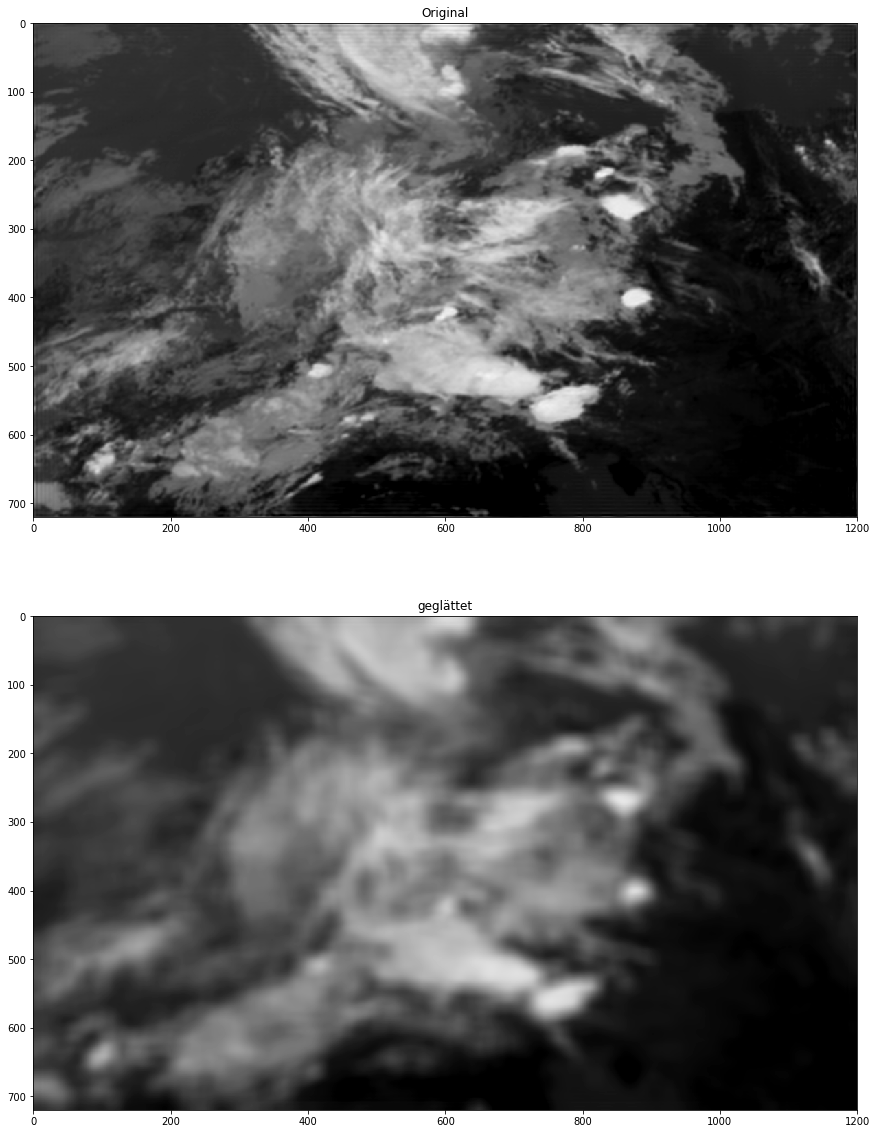

In [157]:
fig,ax = plt.subplots(2,1,figsize = (16,20))
ax[0].imshow(sat_data['IR_108'][0],vmin=210,vmax=300,cmap='gray_r')
ax[0].set_title("Original")
ax[1].imshow(ir_smooth[0],vmin=210,vmax=300,cmap='gray_r')
ax[1].set_title(u"geglättet")

Nun können wir das Bewegungsfeld ermitteln.

In [158]:
ir_movement = tc.oft.calculate_optical_flow([sat_data['IR_108'][0],sat_data['IR_108'][1]],'farnebaeck')

Mit diesem Flussfeld, wird jetzt das HRV-Bild des Zeitpunktes t-1 auf t verschoben.

In [159]:
hrv_moved = oflow.morph_trans_opt_flow(sat_data['HRV'][-2],ir_movement[0])

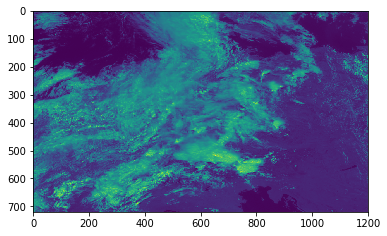

In [160]:
plt.imshow(hrv_moved)

Als nächstes berechnen wir die Differenz zwischen tatsächlichem und geschätzten Bild, um Bereiche mit Wolkenwachstum zu ermitteln.

In [161]:
DHRV = sat_data['HRV'][-1] - hrv_moved

In [162]:
def colourbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

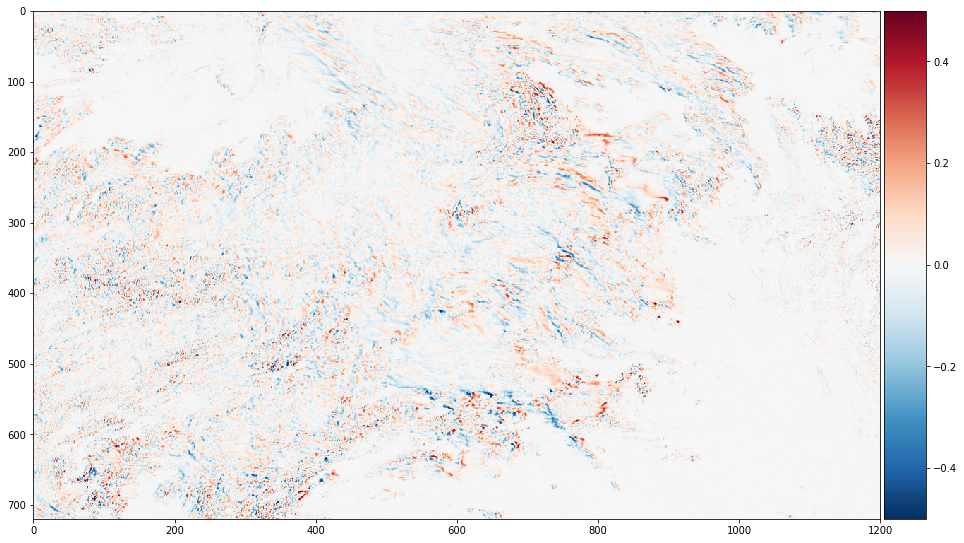

In [163]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(DHRV,vmin=-0.5,vmax=0.5,cmap='RdBu_r')
colourbar(d_plot)

Alle Bereiche mit einem positiven Wert weisen auf Wolkenwachstum hin. Um sicher zu gehen, betrachten wir die IR-Felder.

In [164]:
#wv_hires = [upsample_image(wv) for wv in sat_data['WV_062']]
wv_smooth = [ndi.filters.uniform_filter(wv_field,25) for wv_field in sat_data['WV_062']]
wv_movement = tc.oft.calculate_optical_flow([sat_data['WV_062'][0],sat_data['WV_062'][1]],'farnebaeck')
ir_moved = oflow.morph_trans_opt_flow(sat_data['IR_108'][-2],wv_movement[0])

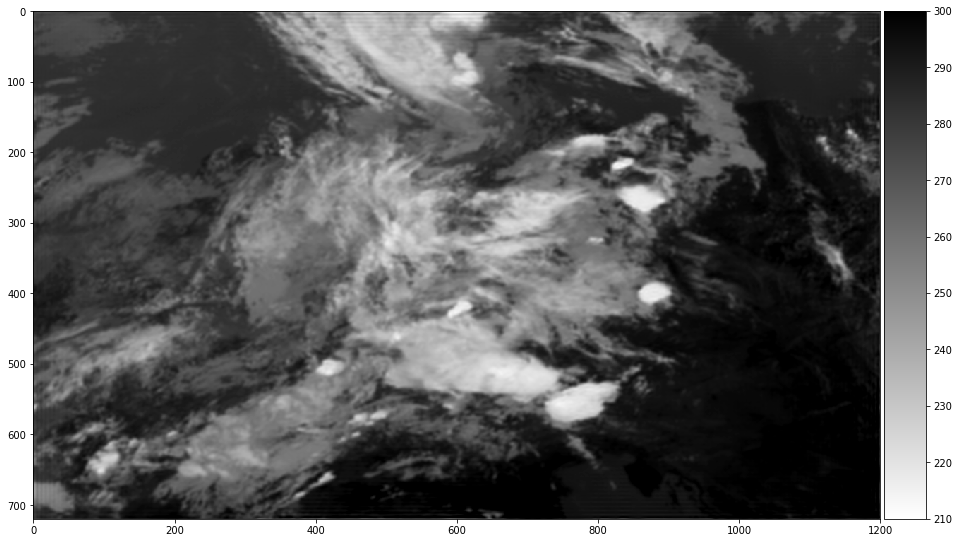

In [165]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(ir_moved,vmin=210,vmax=300,cmap='gray_r')
colourbar(d_plot)

In [166]:
DIR = sat_data['IR_108'][-1] - ir_moved

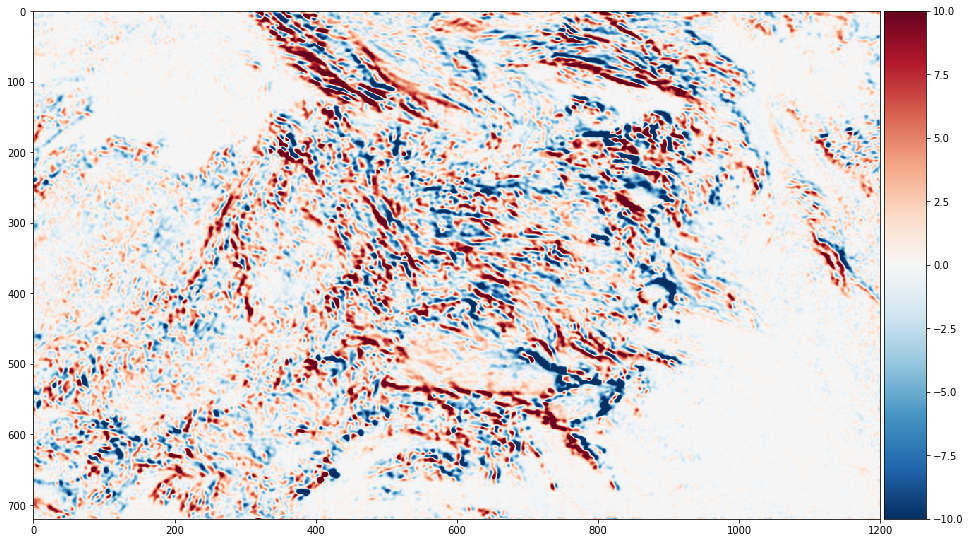

In [168]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(DIR,vmin=-10,vmax=10,cmap='RdBu_r')
colourbar(d_plot)

Hier deuten alle Bereiche mit einer Abkühlung auf Wolkenwachstum hin.

Als nächstes werden beide Felder normalisiert.

In [300]:
DIR_norm = tc.scale_array_min_max(DIR,new_max=1,new_min=-1)
DHRV_norm = tc.scale_array_min_max(DHRV,new_max=1,new_min=-1)

Text(0.5,1,'$\\Delta$HRV, normalisiert')

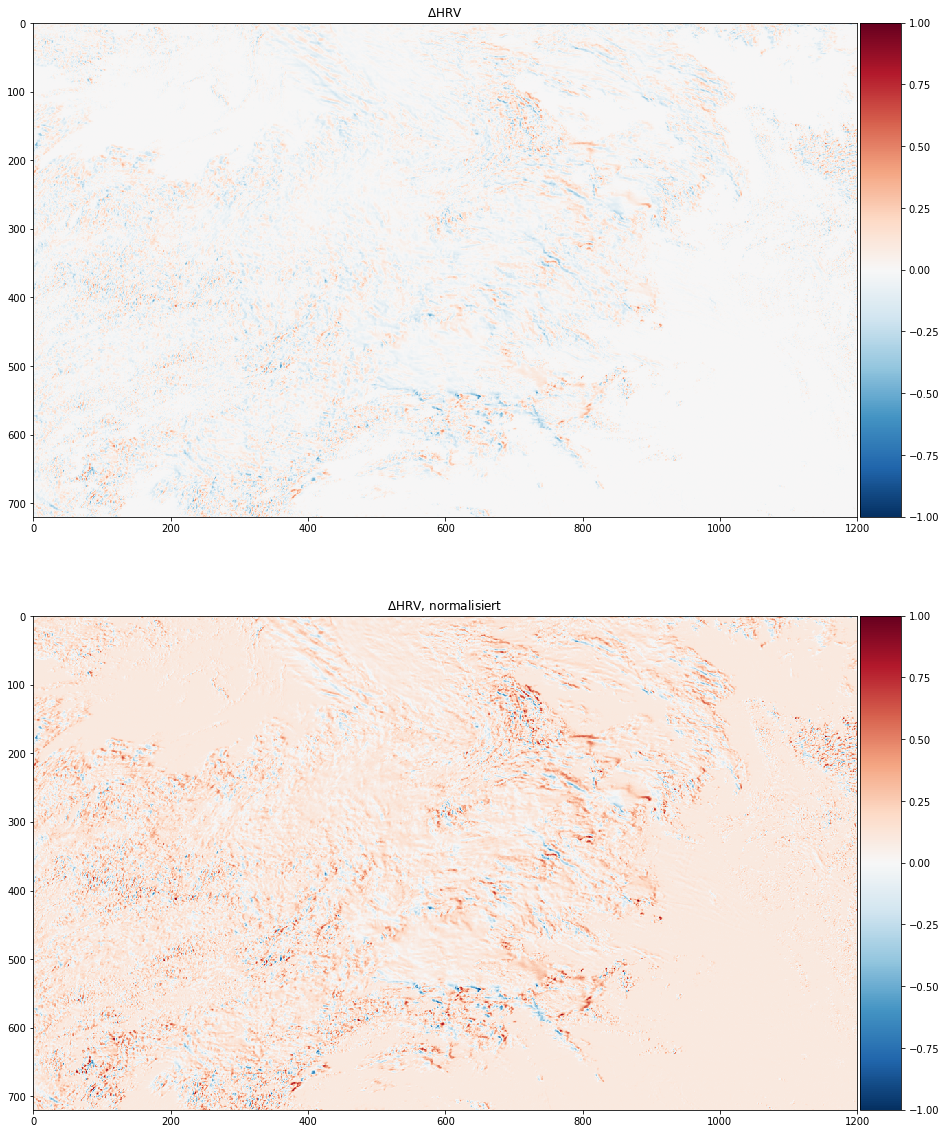

In [303]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hrv_plot = ax[0].imshow(DHRV,vmin=-1,vmax=1,cmap='RdBu_r')
colourbar(hrv_plot)
ax[0].set_title(r"$\Delta$HRV")
hrv1_plot = ax[1].imshow(DHRV_norm,vmin=-1,vmax=1,cmap='RdBu_r')
colourbar(hrv1_plot)
ax[1].set_title(r"$\Delta$HRV, normalisiert")

Daraus wird jetzt der Indikator für das Wolkenwachstum berechnet.

In [304]:
indicator = -DHRV_norm * DIR_norm

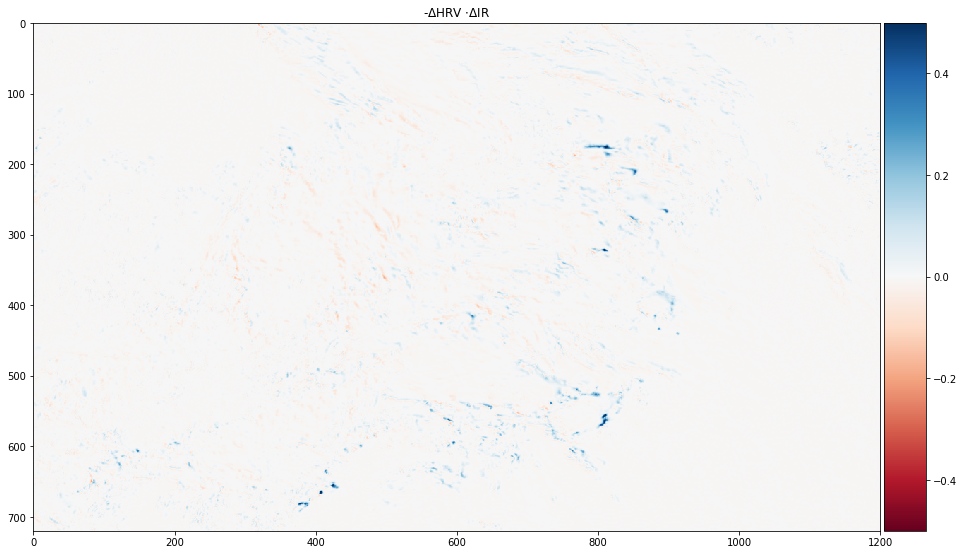

In [305]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
indd_plot = ax.imshow(indicator,vmin=-.5,vmax=.5,cmap='RdBu')
ax.set_title(r"-$\Delta$HRV $\cdot \Delta$IR")
colourbar(indd_plot)

Die blauen Bereiche sind Regionen mit Wolkenwachstum und die roten welche mit Wolkenauflösung.

Um wirklich interessante Objekte zu erhalten, muss ein Schwellwert auf das Feld angewendet werden. In Zinner et at. (2008) wird dreimal die Standardabweichung für die ΔHRV- und ΔIR-Felder verwendet. Wie der Schwellwert genau berechnet wird, wird nicht angegeben. Da die Felder im Bereich -1 bis 1 normalisiert werden, sollte, wenn sie normal verteilt sind, der Mittelwert 0 sein. Daher sollte $3\sigma$ oder $-3\sigma$ direkt als Schwellwert benutzt werden können. Für den HRV-Kanal kommt noch hinzu, dass alle Bereiche mit einer Reflektivität von wengier als 0,5 ausmaskiert werden.

In [330]:
threshold_DHRV = 3* np.std(DHRV_norm)
threshold_DIR = - 3* np.std(DIR_norm)

In [331]:
threshold_DHRV

0.2984714807679782

In [332]:
threshold_DIR 

-0.2362913088306438

In [333]:
threshold_indicator = -threshold_DHRV * threshold_DIR
threshold_indicator

0.0705262168392859

In [343]:
DHRV_objects = np.ma.masked_less(DHRV_norm,threshold_DHRV)
DHRV_objects = np.ma.masked_less(DHRV_objects,0.5)

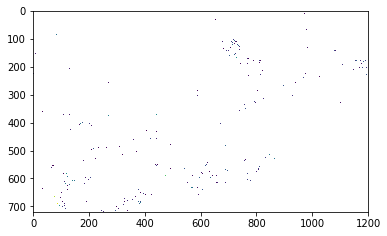

In [344]:
plt.imshow(DHRV_objects*1)

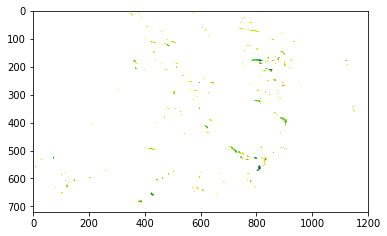

In [345]:
DIR_objects = np.ma.masked_greater(DIR_norm,threshold_DIR)
plt.imshow(DIR_objects*1)

In [357]:
hrv_mask = np.ma.masked_less(np.clip(sat_data['HRV'][-1],0,1),0.5)
level1_mask = np.ma.masked_less(indicator,threshold_indicator)

level1_mask = ~hrv_mask.mask & ~level1_mask.mask

Text(0.5,1,u'Objekte mit konvektiver Ausl\xf6sung')

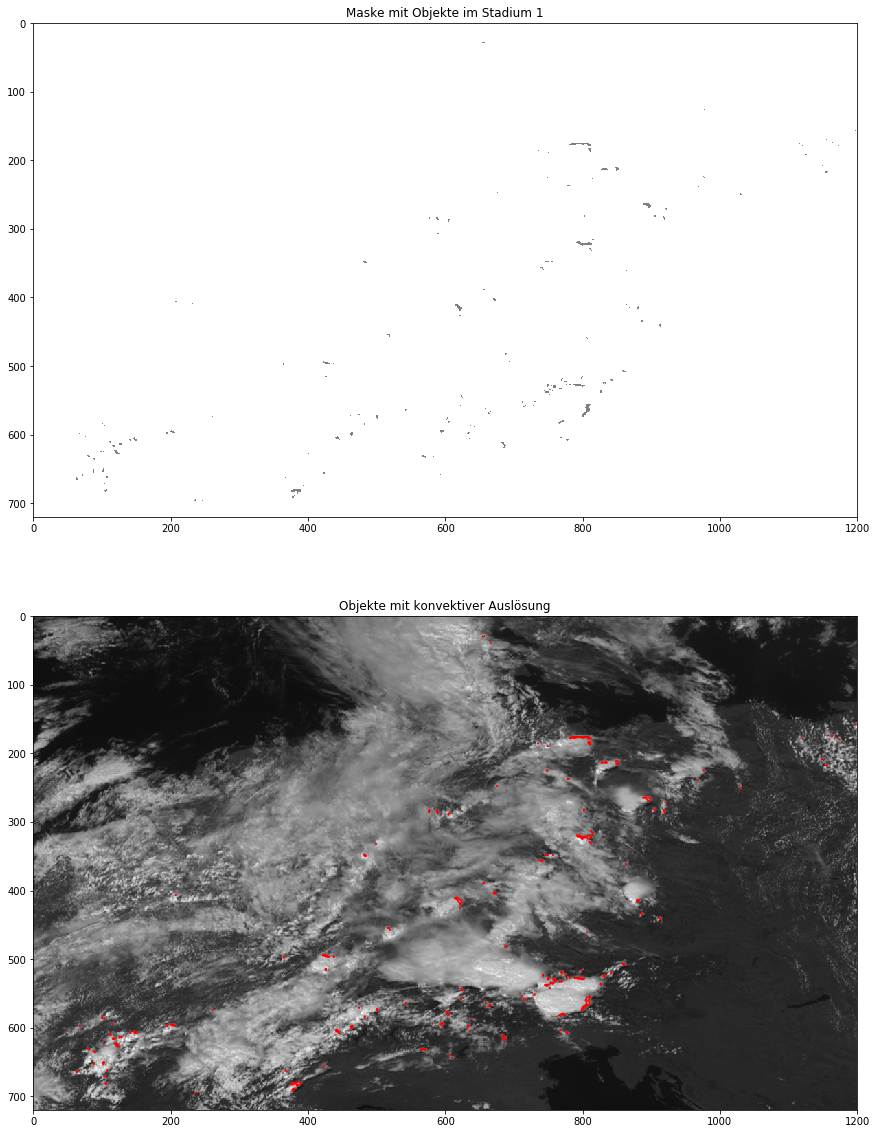

In [359]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].imshow(~level1_mask,vmin=-1,vmax=1,cmap='gray')
ax[0].set_title(u"Maske mit Objekte im Stadium 1")
ax[1].imshow(np.clip(sat_data['HRV'][-1],0,1),vmin=0,vmax=1,cmap='gray')
ax[1].contour(~level1_mask*1,levels=1,colors='red')
ax[1].set_title(u"Objekte mit konvektiver Auslösung")

Das sieht im Großen und Ganzen recht vernünftig aus.

## Stadium 2: rasche Abkühlung

Dann versuchen wir mal Objekte des 2. Stadiums zu finden.

Dafür gehen wir genauso vor, wie zuvor, nur dass wir jetzt den WV062-Kanal benutzen. Der Fluss stammt auch von diesem Kanal, aber von den zwei Zeitschritten zuvor.

In [315]:
wv_moved = oflow.morph_trans_opt_flow(sat_data['WV_062'][1],wv_movement[0])

DWV = sat_data['WV_062'][-1] - wv_moved

Text(0.5,1,'$\\Delta$WV')

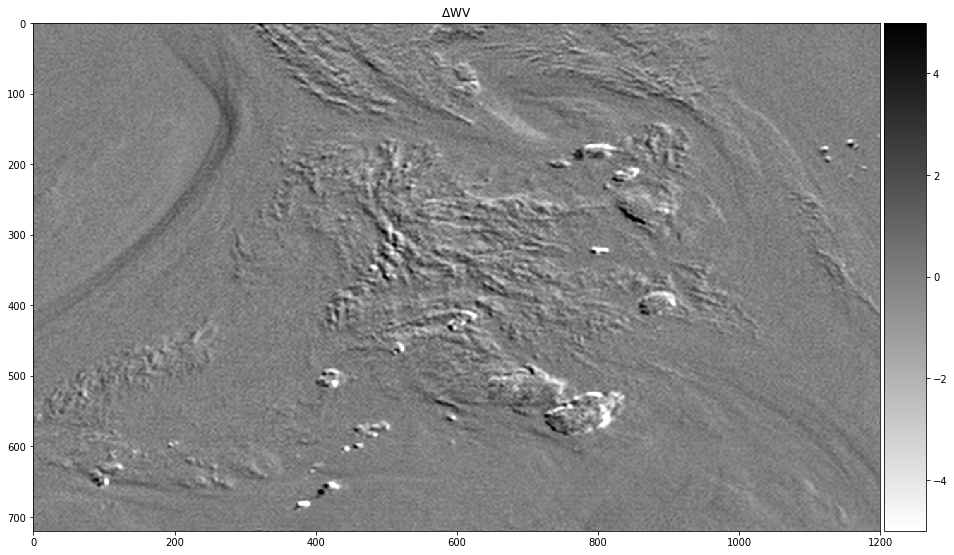

In [316]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(DWV,vmin=-5,vmax=5,cmap='binary')
colourbar(wv_plot)
ax.set_title(r"$\Delta$WV")

Die hellen Bereiche reflektieren Gebiete mit Abkühlung und die dunklen welche mit Erwärmung.

In [325]:
DWV_norm = tc.scale_array_min_max(DWV,new_max=1,new_min=-1)
#threshold_DWV = np.mean(DWV_norm) - 3 * np.std(DWV_norm)
threshold_DWV = - 3 * np.std(DWV_norm)

#level2_mask = np.ma.masked_greater(DWV_norm,-threshold_DWV)
level2_mask = np.ma.masked_greater(DWV_norm,threshold_DWV)

Text(0.5,1,'$\\Delta$WV, normalisiert')

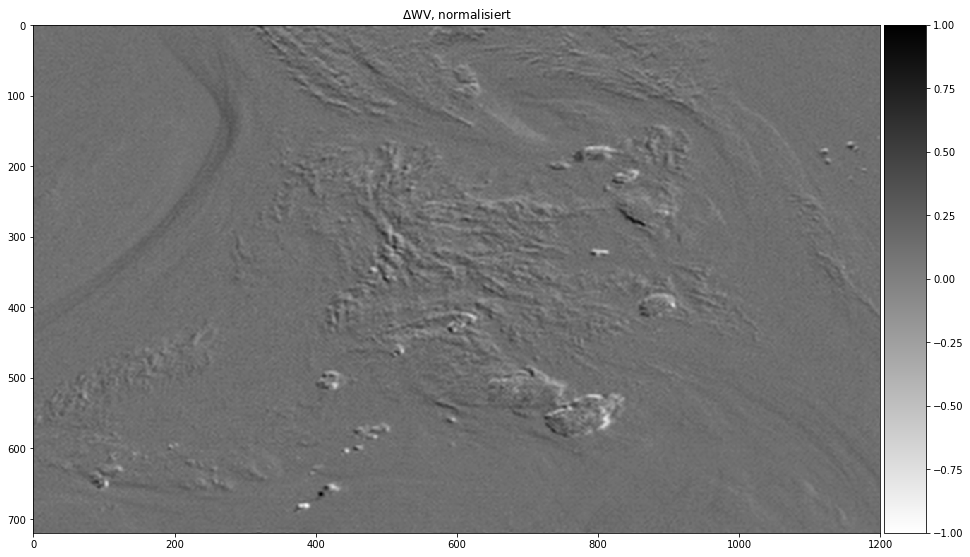

In [326]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(DWV_norm,vmin=-1,vmax=1,cmap='binary')
colourbar(wv_plot)
ax.set_title(r"$\Delta$WV, normalisiert")

In [320]:
3 * np.std(DWV_norm)

0.19226223906083953

(array([3.00000e+00, 3.00000e+00, 1.00000e+00, 8.00000e+00, 1.30000e+01,
        1.40000e+01, 3.80000e+01, 7.00000e+01, 6.50000e+01, 1.33000e+02,
        1.30000e+02, 1.58000e+02, 2.13000e+02, 3.29000e+02, 4.94000e+02,
        7.30000e+02, 1.14000e+03, 2.15100e+03, 4.87000e+03, 1.07930e+04,
        2.71170e+04, 1.18960e+05, 4.24495e+05, 2.03333e+05, 4.36080e+04,
        1.51100e+04, 5.74800e+03, 2.20100e+03, 9.46000e+02, 4.96000e+02,
        2.55000e+02, 1.58000e+02, 8.00000e+01, 4.10000e+01, 3.30000e+01,
        2.20000e+01, 2.90000e+01, 7.00000e+00, 1.00000e+00, 4.00000e+00]),
 array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
        -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
        -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
         0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
         0.8 ,  0.85,  0.9 ,  0.95,  1.  ]),
 <a list of 40 Patch objects>)

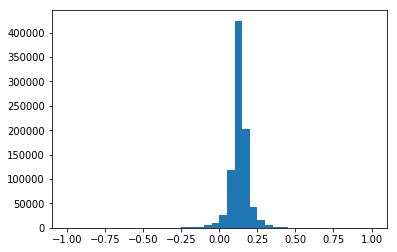

In [327]:
plt.hist(DWV_norm.ravel(),bins=40)

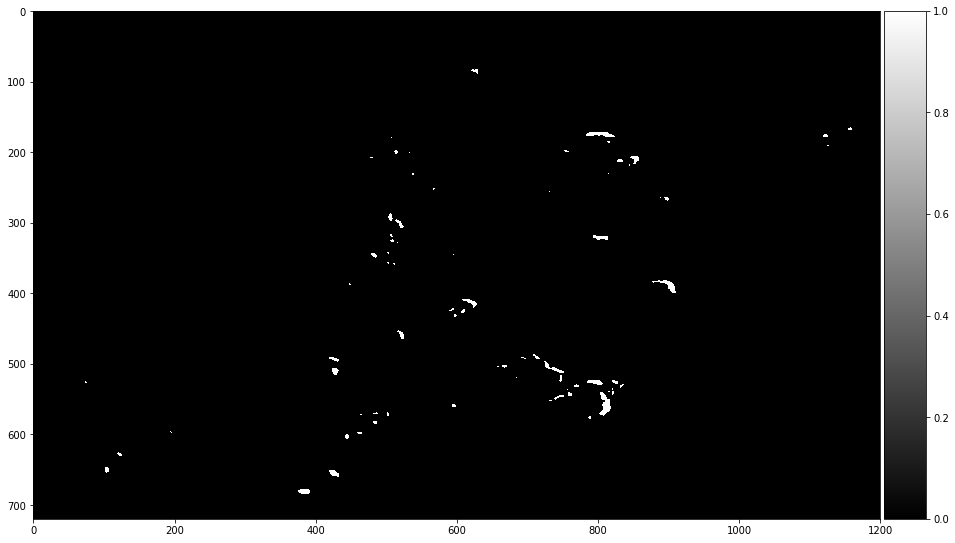

In [361]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(~level2_mask.mask*1,vmin=0,vmax=1,cmap='binary_r')
colourbar(wv_plot)

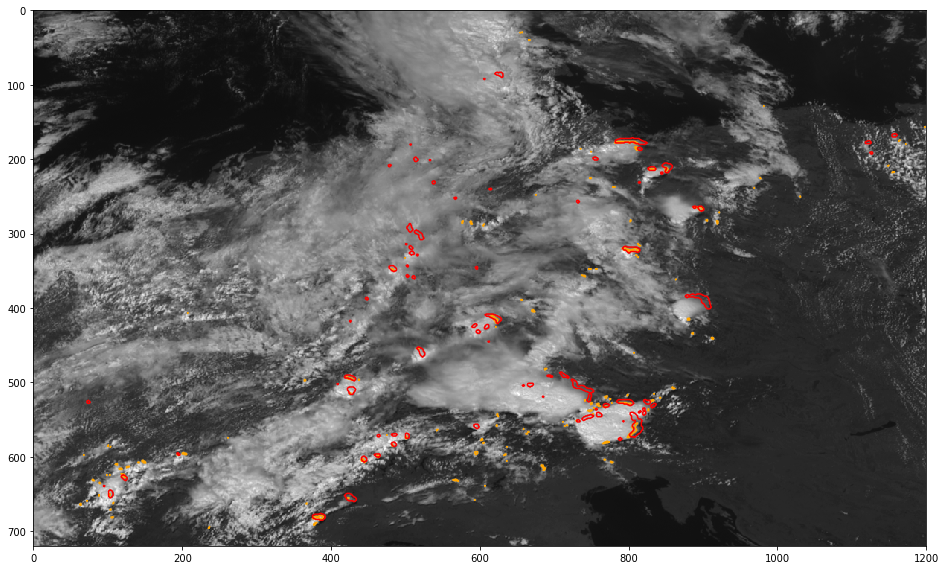

In [362]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(sat_data['HRV'][-1],0,1),vmin=0,vmax=1,cmap='gray')
ax.contour(~level1_mask*1,levels=1,colors='orange')
ax.contour(~level2_mask.mask*1,levels=1,colors='red')

In [366]:
combined_masks = np.zeros_like(s.ref['HRV'])

combined_masks[np.where(level1_mask==True)] = 1
combined_masks[np.where(level2_mask.mask==False)] = 2

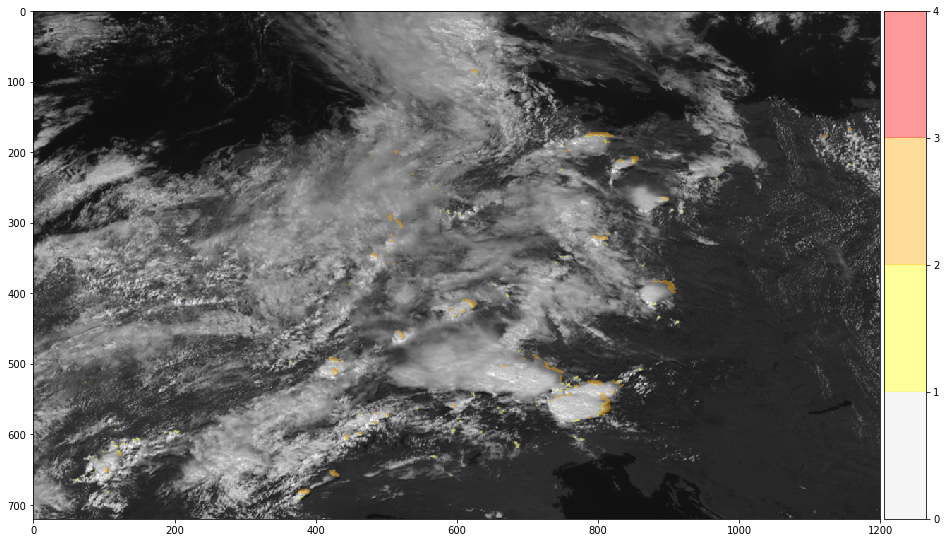

In [369]:
from matplotlib import colors

# make a color map of fixed colors
cmap = colors.ListedColormap([(0.9,0.9,0.9,0),'yellow','orange','red'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(sat_data['HRV'][-1],0,1),vmin=0,vmax=1,cmap='gray')
level_plot = ax.imshow(combined_masks,cmap=cmap, norm=norm, alpha=0.4)
colourbar(level_plot)

Das sieht im Großen ung Ganzen auch vernünftig aus.

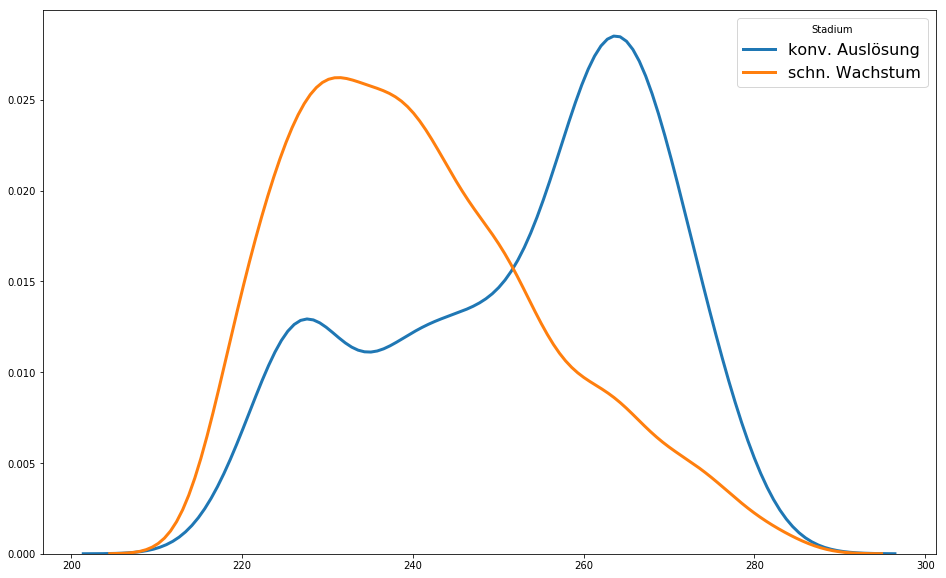

In [368]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(16,10))
levels = {1:u'konv. Auslösung', 2:'schn. Wachstum'}
for level in [1,2]:
    values = sat_data['IR_108'][-1][np.where(combined_masks==level)]
    
    # Draw the density plot
    sns.distplot(values, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = levels[level],ax=ax)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Stadium')
#plt.title('Density Plot with Multiple Airlines')
#plt.xlabel('Delay (min)')
#plt.ylabel('Density')

Als nächstes ein Versuch Objekte zu verfolgen.

## Tracking der Objekte

Dafür lagern wir die Operationen in Funktionen aus und laden zunächst ein paar mehr Zeitschritte.

In [393]:
def calculate_normalised_difference(array,array_guess):
    difference = array - array_guess

    return tc.scale_array_min_max(difference,new_max=1,new_min=-1)


def detect_cbtram_level1(hrv_data,ir_data,wv_data,flow_method):
    """
    Detects CbTRAM objects of stage 1.

    Inputs:
    hrv_data: stack or list of numpy arrays
        HRV data to use for detection
    ir_data: stack or list of numpy arrays
        IR108 data corresponding to the HRV data, used for motion estimation
    wv_data: stack or list of numpy arrays
        WV062 data corresponding to the HRV data, used for motion estimation
    flow_method: string, possible: farnebaeck, tvl1
        identifier of the method to use for the motion estimation

    Returns:
    level1_mask: binary numpy array
        array with objects of stage 1
    """
    
    # estimate motion
    ir_movement = tc.oft.calculate_optical_flow([ir_data[-2],ir_data[-1]],flow_method)
    wv_movement = tc.oft.calculate_optical_flow([wv_data[-2],wv_data[-1]],flow_method)
    
    # determine HRV difference
    hrv_moved = oflow.morph_trans_opt_flow(hrv_data[-2],ir_movement[0])

    DHRV = calculate_normalised_difference(hrv_data[-1],hrv_moved)

    # determin IR difference
    ir_moved = oflow.morph_trans_opt_flow(ir_data[-2],wv_movement[0])

    DIR = calculate_normalised_difference(ir_data[-1],ir_moved)

    # calculate indicator field
    indicator_field = -DHRV * DIR

    # determine thresholds
    HRV_threshold = 3 * np.std(DHRV)
    IR_threshold = -3 * np.std(DIR)

    indicator_threshold = -HRV_threshold * IR_threshold

    # get level 1 objects
    level1_mask = np.zeros_like(hrv_data[-1])
    level1_mask = np.ma.masked_less(indicator,threshold_indicator)
    
    # also mask all HRV pixels with less than 0.5    
    hrv_mask = np.ma.masked_less(hrv_data[-1],0.5)

    # combine masks
    level1_mask = ~hrv_mask.mask & ~level1_mask.mask

    return level1_mask*1
                                          
def detect_cbtram_level2(wv_data,flow_method):
    """
    Detects CbTRAM objects of stage 2.

    Inputs:
    wv_data: stack or list of numpy arrays
        WV062 to detect objects in
    flow_method: string, possible: farnebaeck, tvl1
        identifier of the method to use for the motion estimation

    Returns:
    level2_mask: binary numpy array
        array with objects of stage 2
    """
    
    # estimate motion
    wv_movement = tc.oft.calculate_optical_flow([wv_data[-3],wv_data[-2]],flow_method)
    
    # determine WV difference
    wv_moved = oflow.morph_trans_opt_flow(wv_data[-2],wv_movement[0])

    DWV = calculate_normalised_difference(wv_data[-1],wv_moved)

    # determine threshold
    WV_threshold = -3 * np.std(DWV)

    # get level 2 objects
    level2_mask = np.ma.masked_greater(DWV_norm,threshold_DWV)
    
    return ~level2_mask.mask*1                                          

In [409]:
tlist = []
deltat = dt.timedelta(minutes=5)

start_time = dt.datetime(2012,7,28,10,45)
end_time = dt.datetime(2012,7,28,12,0)

while start_time <= end_time:
    tlist.append(start_time)
    start_time += deltat

In [410]:
tlist

[datetime.datetime(2012, 7, 28, 10, 45),
 datetime.datetime(2012, 7, 28, 10, 50),
 datetime.datetime(2012, 7, 28, 10, 55),
 datetime.datetime(2012, 7, 28, 11, 0),
 datetime.datetime(2012, 7, 28, 11, 5),
 datetime.datetime(2012, 7, 28, 11, 10),
 datetime.datetime(2012, 7, 28, 11, 15),
 datetime.datetime(2012, 7, 28, 11, 20),
 datetime.datetime(2012, 7, 28, 11, 25),
 datetime.datetime(2012, 7, 28, 11, 30),
 datetime.datetime(2012, 7, 28, 11, 35),
 datetime.datetime(2012, 7, 28, 11, 40),
 datetime.datetime(2012, 7, 28, 11, 45),
 datetime.datetime(2012, 7, 28, 11, 50),
 datetime.datetime(2012, 7, 28, 11, 55),
 datetime.datetime(2012, 7, 28, 12, 0)]

In [445]:
sat_fields = ['HRV','IR_108','WV_062']

region = ((216, 456), (1676, 2076)) # Mitteleuropa

sat_data = {f:[] for f in sat_fields}
for t in tlist:
    print t
    s = msv.MSevi(time=t,chan_list=sat_fields,region=region)
    s.rad2bt()
    s.rad2refl()

    for field in sat_fields[1:]:
        im = msh.upsample_image(s.bt[field],1,0)
        sat_data[field].append(im)
    
    sat_data['HRV'].append(s.ref['HRV'])

2012-07-28 10:45:00
Region suggests use of hdf file
2012-07-28 10:50:00
Region suggests use of hdf file
2012-07-28 10:55:00
Region suggests use of hdf file
2012-07-28 11:00:00
Region suggests use of hdf file
2012-07-28 11:05:00
Region suggests use of hdf file
2012-07-28 11:10:00
Region suggests use of hdf file
2012-07-28 11:15:00
Region suggests use of hdf file
2012-07-28 11:20:00
Region suggests use of hdf file
2012-07-28 11:25:00
Region suggests use of hdf file
2012-07-28 11:30:00
Region suggests use of hdf file
2012-07-28 11:35:00
Region suggests use of hdf file
2012-07-28 11:40:00
Region suggests use of hdf file
2012-07-28 11:45:00
Region suggests use of hdf file
2012-07-28 11:50:00
Region suggests use of hdf file
2012-07-28 11:55:00
Region suggests use of hdf file
2012-07-28 12:00:00
Region suggests use of hdf file


In [446]:
#level1_masks = []
#level2_masks = []
combi_masks = {t.strftime("%Y%m%dT%H%M"):[] for t in tlist[3:]}

for i in xrange(3,len(sat_data['HRV'])):
    print i
    hrv_subset = sat_data['HRV'][i-2:i]
    ir_subset = sat_data['IR_108'][i-2:i]
    wv_subset = sat_data['WV_062'][i-3:i]
    
    level1 = detect_cbtram_level1(hrv_subset,ir_subset,wv_subset,'farnebaeck')
    level2 = detect_cbtram_level2(wv_subset,'farnebaeck')
    
    combined_mask = np.zeros_like(sat_data['HRV'][0])

    combined_mask[np.where(level1==1)] = 1
    combined_mask[np.where(level2==1)] = 2
    
    #level1_masks.append(level1)
    #level2_masks.append(level2)
    combi_masks[sorted(tlist)[i].strftime("%Y%m%dT%H%M")] = combined_mask

3
4
5
6
7
8
9
10
11
12
13
14
15


In [444]:
hrv_subset

[array([[0.13562664, 0.13828599, 0.17418716, ..., 0.40820961, 0.35768203,
         0.30316544],
        [0.18615422, 0.20742899, 0.24067081, ..., 0.34172596, 0.28986871,
         0.23668179],
        [0.22205539, 0.25263787, 0.27125329, ..., 0.28455002, 0.23934114,
         0.20343997],
        ...,
        [0.61829794, 0.60367153, 0.56910004, ..., 0.14493436, 0.14626403,
         0.1475937 ],
        [0.60101219, 0.59170448, 0.56378135, ..., 0.14626403, 0.14626403,
         0.14493436],
        [0.60633088, 0.5956935 , 0.58904513, ..., 0.14892337, 0.14360468,
         0.14227501]]),
 array([[0.14094534, 0.14626403, 0.16620912, ..., 0.24067081, 0.26726427,
         0.2606159 ],
        [0.16620912, 0.19812127, 0.2313631 , ..., 0.23269277, 0.24864885,
         0.22870375],
        [0.19147291, 0.22471473, 0.26327525, ..., 0.25662689, 0.27923133,
         0.25130819],
        ...,
        [0.59303415, 0.57840775, 0.54915494, ..., 0.14493436, 0.14493436,
         0.14493436],
        [0.6

IndexError: index 12 is out of bounds for axis 0 with size 12

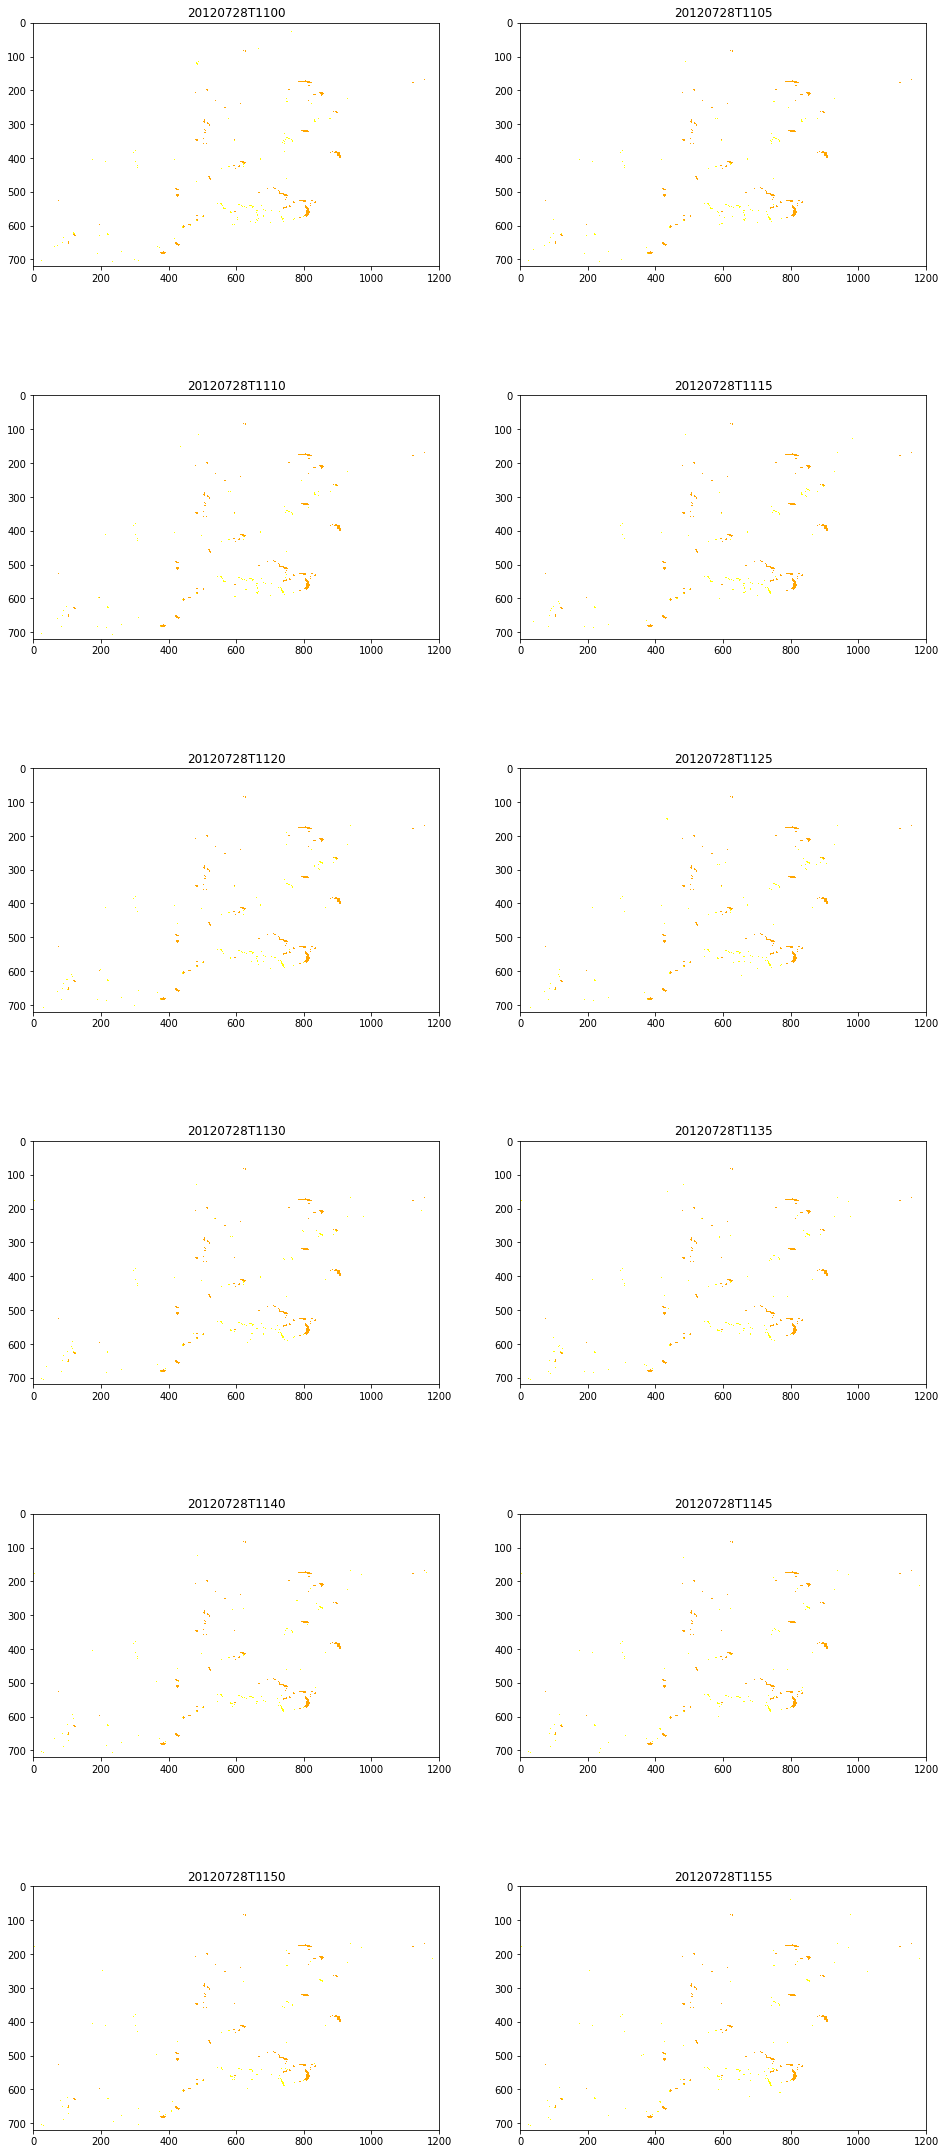

In [443]:
fig,ax = plt.subplots(len(combi_masks.keys())/2,2,figsize=(16,40))
axs=ax.ravel()
for i,c in enumerate(sorted(combi_masks.keys())):
    #axs[i].imshow(np.clip(sat_data['HRV'][i+2],0,1),vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(combi_masks[c],cmap=cmap,norm=norm)
    axs[i].set_title(c)

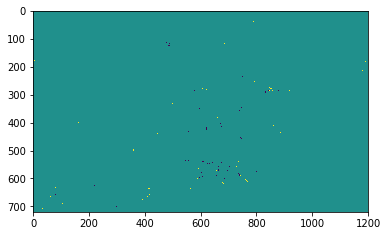

In [450]:
plt.imshow(combi_masks['20120728T1200']- combi_masks['20120728T1100'])

In [441]:
combi_masks

{'20120728T1055': [], '20120728T1100': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), '20120728T1105': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), '20120728T1110': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), '20120728T1115': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.]